# Interpolation

The metocean datasets for velocity are on regular, uniform grids. We need to be able to estimate the velocity at sub-grid scale.  This notebooks explores making that estimate using interpolation.

[Wikipedia: Interpolation](https://en.wikipedia.org/wiki/Interpolation)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Interpolation_example_linear.svg/512px-Interpolation_example_linear.svg.png"/>

Since this is critical aspect of our project, this notebook explores difference approaches to interpolation and provides examples for related test cases.

## Scipy.interpolate

In [1]:
import scipy.interpolate as interp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Suppose we have the data:

In [2]:
x = np.array([0, 2, 4, 6, 8])
y = np.array([0, 1, 4, 9, 0])

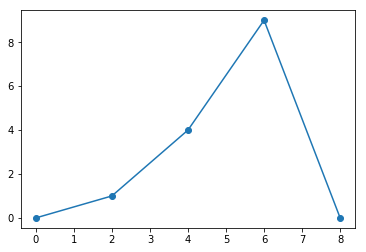

In [3]:
plt.plot(x, y, 'o-')

In [56]:
def get_interpolated_value(grid, data, point):
  
    while data.ndim > 0:
        x0, dx = grid[0]
        x_pt = point[0]
    
        x_idx = (x_pt - x0)/dx
        
        x_idx0 = int(np.floor(x_idx))
        dx_idx = (x_idx - x_idx0)
        
        A = data[x_idx0:x_idx0+2, ...]
        data = (1-dx_idx)*A[0,...] + (dx_idx)*A[1,...]
        grid = grid[1:]
        point = point[1:]
    
           
    return data

# 1-D test case


In [5]:
# We can interpolate using scipy.interpolate.interp1d

point = 6.5

f = interp.interp1d(x, y)
print(f(point))

# or RegularGridInterpolator
g = interp.RegularGridInterpolator( (x,), y)

#interp.RegularGridInterpolator
print(g( [[point,]] ) )

# our interpolator
grid = ((x[0], x[1]-x[0]), )
h = get_interpolated_value(grid, y, (point,))
print(h)

6.75
[ 6.75]
6.75


# 2D test case


In [6]:
x = np.linspace(0, 10, 6, endpoint=True)
y = np.linspace(0, 5, 6, endpoint=True)

X, Y = np.meshgrid(x, y)
Z = np.sin(X*Y)

In [7]:
def test_2d(x0, y0):
    point = (x0, y0)
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    plt.figure(figsize=(12,6))
    #plt.pcolormesh(X, Y, Z, cmap='viridis')
    plt.imshow(Z, extent=[x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2], 
           interpolation='nearest',
           origin='lower',)
    plt.colorbar()
    plt.scatter(X, Y)
    plt.scatter(*point, color='r', marker='x', s=150)


    f = interp.interp2d(x, y, Z)
    print(f(*point))

    # or RegularGridInterpolator
    g = interp.RegularGridInterpolator( (x,y), Z)
    #interp.RegularGridInterpolator
    print(g( [point,] ) )

    # our interpolator
    grid = ((x[0], dx), (y[0], dy) )
    h = get_interpolated_value(grid, Z, point)
    print(h)

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

[ 0.22639266]
[ 0.22639266]
0.226392664311


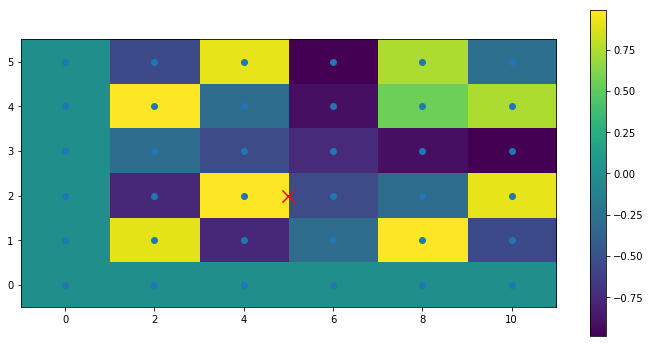

<function __main__.test_2d>

In [9]:
interact( test_2d, x0=(0,10, 0.1), y0=(0,5, 0.1))

# Test 3d

In [10]:
x = np.linspace(0, 10, 6, endpoint=True)
y = np.linspace(0, 5, 6, endpoint=True)
z = np.linspace(0, 20, 6, endpoint=True)
X, Y, Z = np.meshgrid(x, y, z)
Q = np.sin(X*Y*Z)

In [11]:
def test_3d(x0, y0, z0):
    point = (x0, y0, z0)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dz = z[1] - z[0]

    f = interp.interpn((x, y, z), Q, point)
    print(f)

    # or RegularGridInterpolator
    g = interp.RegularGridInterpolator( (x,y,z), Q)
    #interp.RegularGridInterpolator
    print(g( [point,] ) )

    # our interpolator
    grid = ((x[0], dx), (y[0], dy), (z[0], dz) )
    h = get_interpolated_value(grid, Q, point)
    print(h)

In [12]:
interact( test_3d, x0=(0,10, 0.1), y0=(0,5, 0.1), z0=(0,20,0.1))

[ 0.59904498]
[ 0.59904498]
0.599044983792


<function __main__.test_3d>

# Now with ocean data!

In [13]:
### User can change these variables (unless they begin with an underscore) ###

drift_model = 'turnbull'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'


iip_season = 2015  # must be 2015 (more to come later)

# Uncomment only one of the following
_method = 'index'; iip_indices = range(3283, 3285)  # iip_indices must be int or range
#_method = 'ID'; iip_ID = 20668  # iip_ID must be int

## Imports

In [14]:
from datetime import timedelta
import numpy as np

In [15]:
if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from iceberg.wagner import drift
else:
    print('drift model specified is invalid')
    
from icedef import iceberg, metocean, plot

## Iceberg Data

In [16]:
if _method == 'index':
    identifier = iip_indices
elif _method == 'ID':
    identifier = iip_ID
else:
    print("Invalid method specified. Please change _method to either 'index' or 'ID'")

In [17]:
iip_berg_df, iip_berg = iceberg.get_iip_iceberg(2015, _method, identifier)

/home/evankielley/IceDEF/icedef/iceberg.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.hour, unit='h')
/home/evankielley/IceDEF/icedef/iceberg.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.minute, unit='m')


In [18]:
iip_berg_df

,index,ICEBERG_YEAR,ICEBERG_NUMBER,SIGHTING_DATE,SIGHTING_TIME,SIGHTING_LATITUDE,SIGHTING_LONGITUDE,SIGHTING_METHOD,SIZE,SHAPE,SOURCE,TIMESTAMP
0,3283,2015,20668,6/16/2015,1440,48.20,-50.18,R/V,LG,TAB,GTJZ,2015-06-16 14:40:00
1,3284,2015,20668,6/17/2015,1043,48.16,-50.16,R/V,LG,GEN,GMRS,2015-06-17 10:43:00


In [19]:
mod_berg = iceberg.clone_iceberg_state(iip_berg)

## Metocean Data

In [60]:
%%time
ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

CPU times: user 1.5 s, sys: 1.56 s, total: 3.06 s
Wall time: 23.9 s


In [61]:
%%time
atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

CPU times: user 94.6 ms, sys: 15.2 ms, total: 110 ms
Wall time: 2.1 s


## Timesteps

In [62]:
t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]
t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step_hours = 0.1
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)

In [66]:
# Test Case
time0 = 573791.3994416415
lat0 = 48.199906857329346
lon0 = -50.172364036285984

data = ocean_data.VW

In [67]:
def test_3d_ocean(time0, lat0, lon0):
    point = (time0, lat0, lon0)
    dt = ocean_data.times[1] - ocean_data.times[0]
    dlat = ocean_data.lats[1] - ocean_data.lats[0]
    dlon = ocean_data.lons[1] - ocean_data.lons[0]

    f = interp.interpn((ocean_data.times, ocean_data.lats, ocean_data.lons), data, point)[0]
    print(f, "interpn")

    # or RegularGridInterpolator
    g = interp.RegularGridInterpolator((ocean_data.times, ocean_data.lats, ocean_data.lons), data)
    #interp.RegularGridInterpolator
    print(g([point,][0]), "RegularGridInterpolator")

    # RegularGridInterpolator from metocean 
    #print(ocean_data.iUW([time0, lat0, lon0])[0], "RegularGridInterpolator (metocean)")
    
    # our interpolator
    grid = ((ocean_data.times[0], dt), (ocean_data.lats[0], dlat), (ocean_data.lons[0], dlon) )
    h = get_interpolated_value(grid, data, point)
    print(h, "New algorithm")    

In [68]:
test_3d_ocean(time0, lat0, lon0)

0.00396931461185 interpn
0.0039693146118462965 RegularGridInterpolator
0.0040898383321 New algorithm


# Speed Testing

In [44]:
point = (time0, lat0, lon0)
dt = ocean_data.times[1] - ocean_data.times[0]
dlat = ocean_data.lats[1] - ocean_data.lats[0]
dlon = ocean_data.lons[1] - ocean_data.lons[0]

In [69]:
g = interp.RegularGridInterpolator((ocean_data.times, ocean_data.lats, ocean_data.lons), data)
%timeit g([point,])[0]

461 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [70]:
%timeit interp.interpn((ocean_data.times, ocean_data.lats, ocean_data.lons), data, point)[0]

672 µs ± 9.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [71]:
grid = ((ocean_data.times[0], dt), (ocean_data.lats[0], dlat), (ocean_data.lons[0], dlon))
%timeit get_interpolated_value(grid, data, point)

151 µs ± 2.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
